In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from spicy_snow.processing.s1_preprocessing import s1_dB_to_power

from scipy.stats import pearsonr

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [2]:
dss = [xr.open_dataset(fp) for fp in Path('~/scratch/spicy/SnowEx-Data-params').expanduser().glob('*.nc')]

In [3]:
ds = xr.open_dataset(Path('~/scratch/spicy/SnowEx-Data-params/Banner_2020-02-18.nc'))
ds = [ds for ds in dss if ds.attrs['lidar-flight-time'] == '2021-03-15'][0]

FileNotFoundError: [Errno 2] No such file or directory: '/bsuhome/zacharykeskinen/scratch/spicy/SnowEx-Data-params/Banner_2020-02-18.nc'

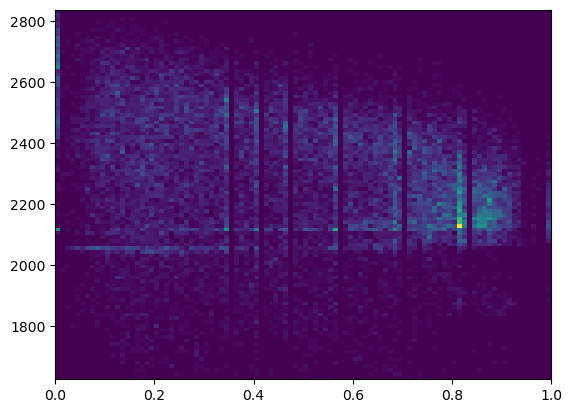

In [ ]:
x = ds['fcf'].values.ravel()
y = ds['lidar-dem'].values.ravel()
idx = (~np.isnan(x)) & (~np.isnan(y))
x, y = x[idx], y[idx]
plt.hist2d(x = x, y = y, bins = 100)
plt.show()

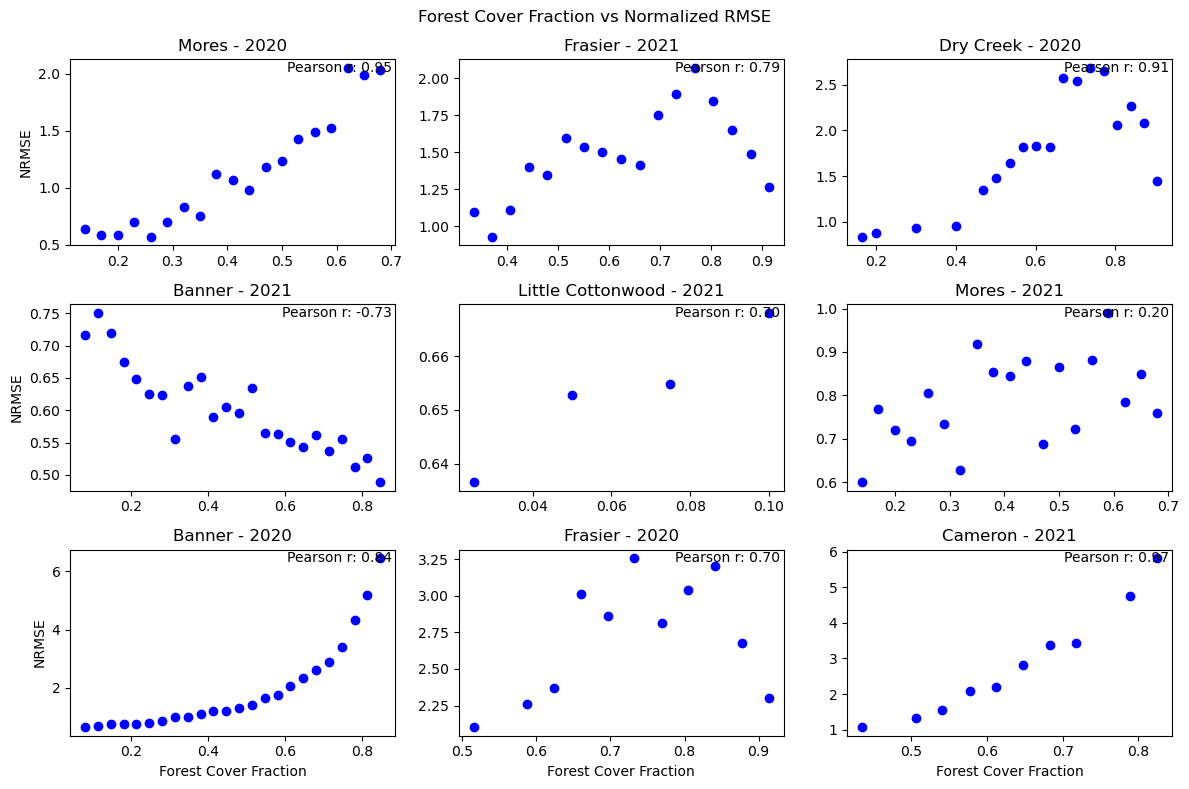

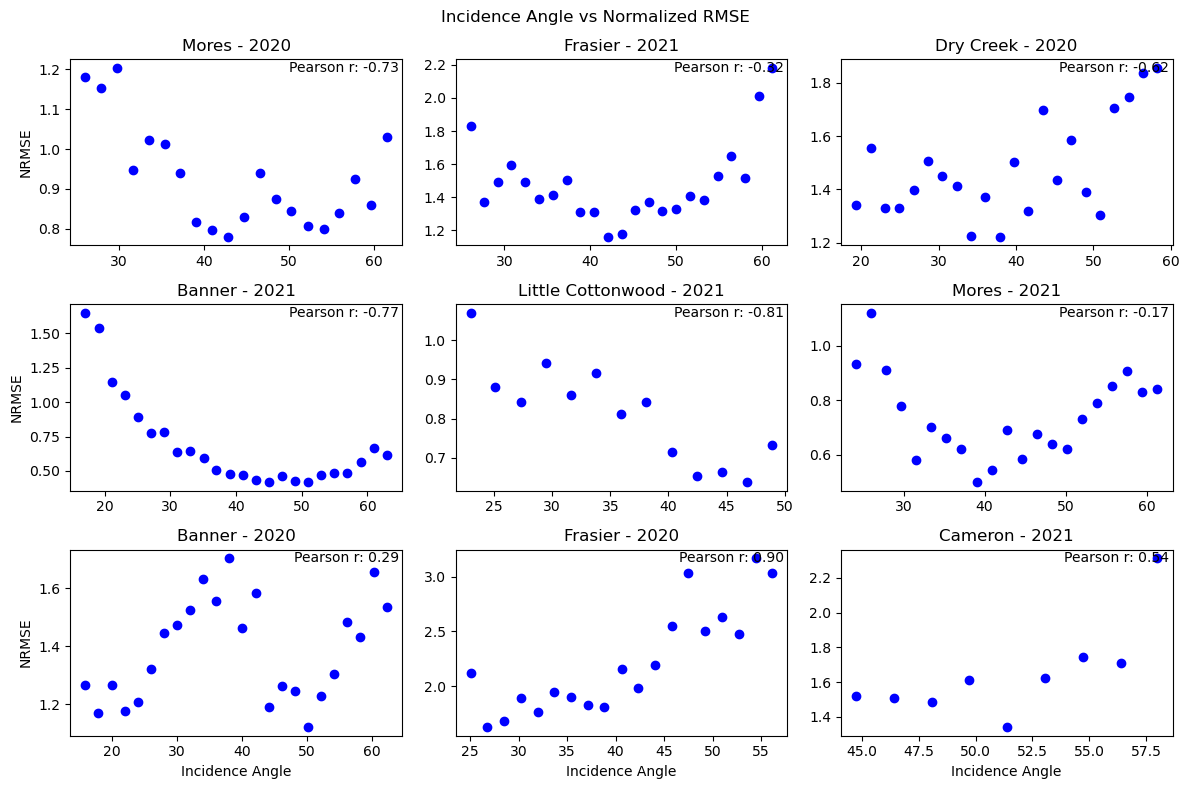

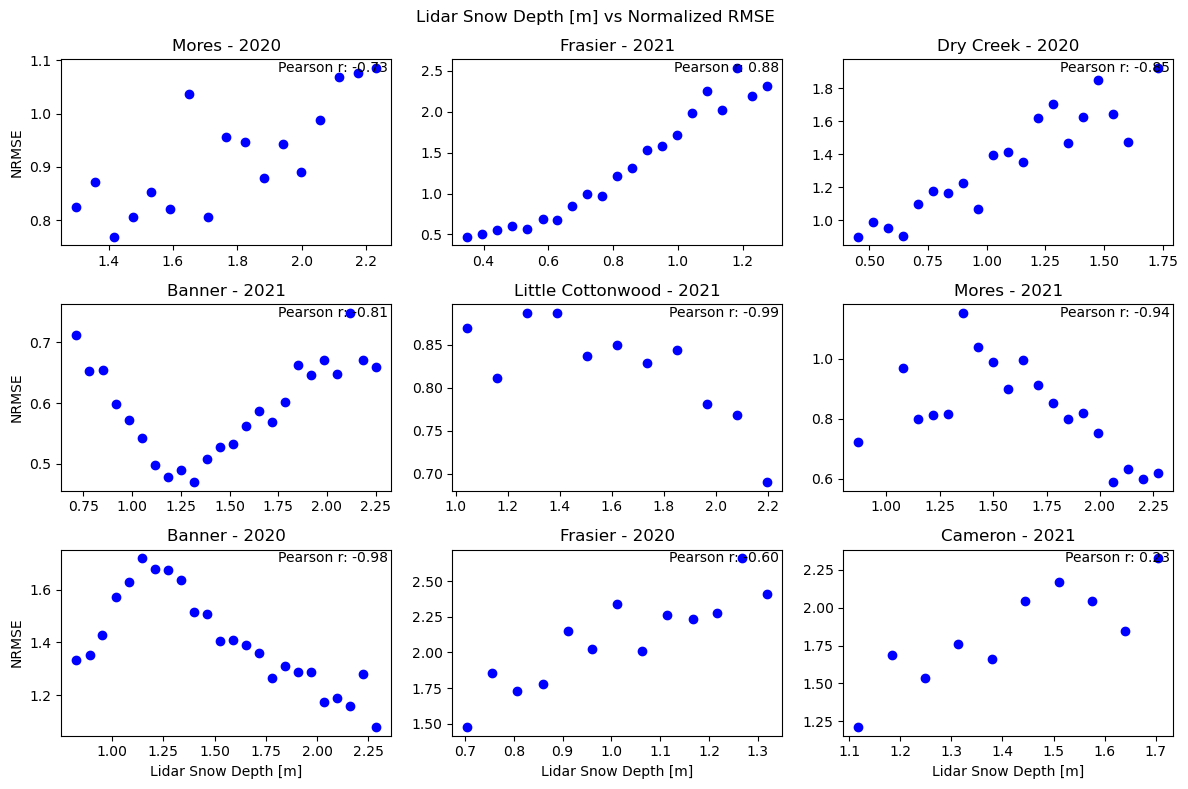

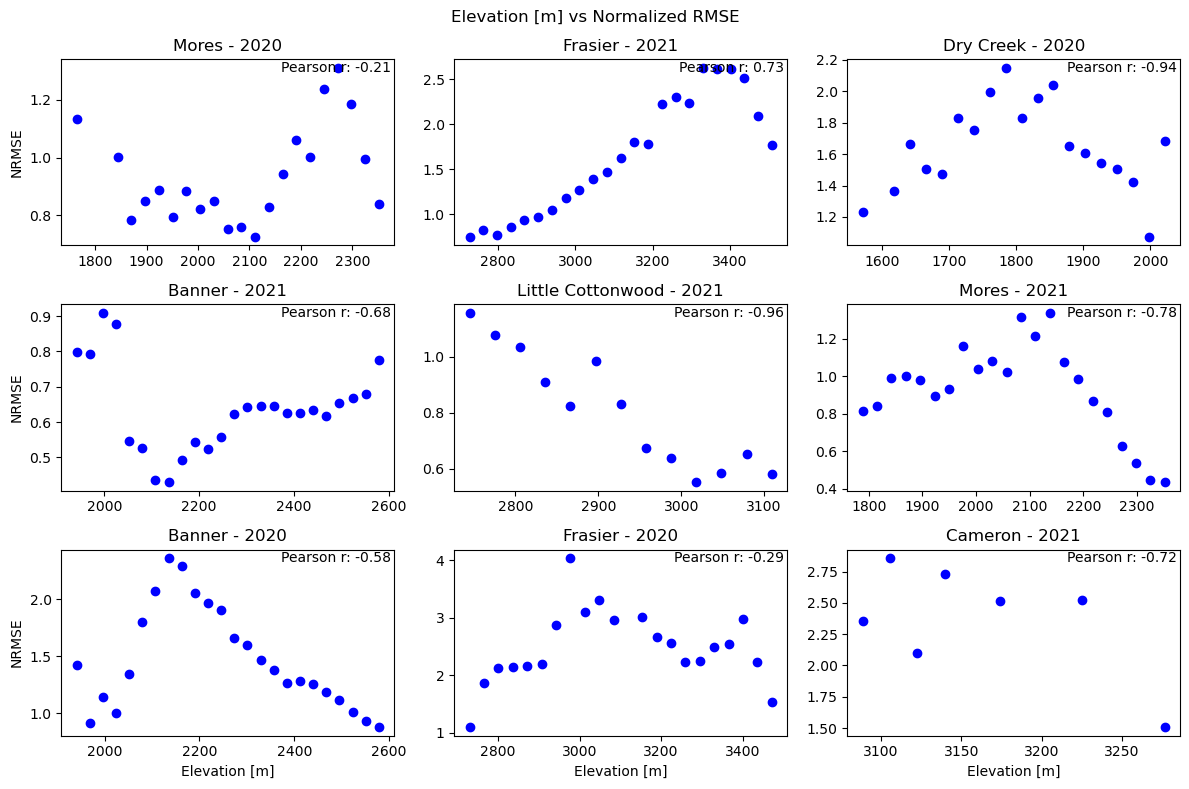

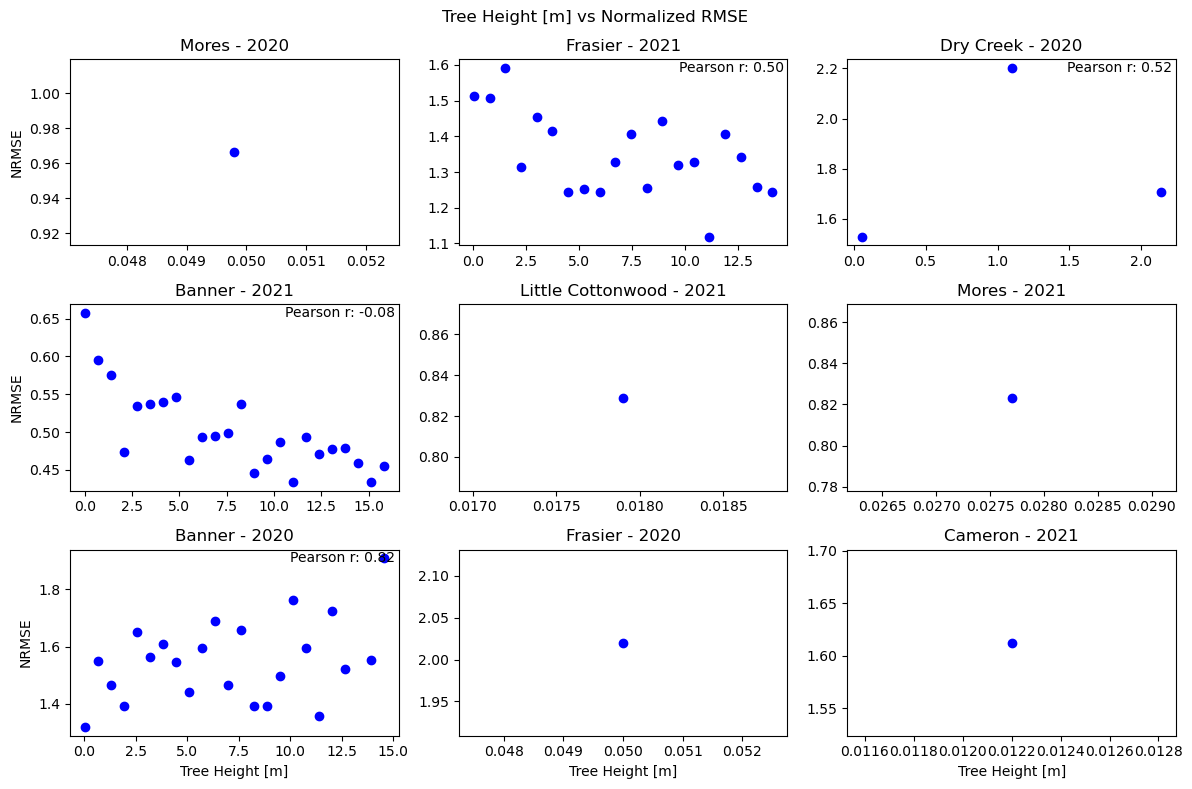

In [ ]:
x_labels = {'fcf':'Forest Cover Fraction', 's1':'Incidence Angle', 'lidar-sd': 'Lidar Snow Depth [m]', 'lidar-dem': 'Elevation [m]', 'lidar-vh': 'Tree Height [m]'}
for var in ['fcf','s1','lidar-sd', 'lidar-dem', 'lidar-vh']:
    fig, axes = plt.subplots(3, 3, figsize = (12,8))
    for ds, ax in zip(dss, axes.ravel()):

        # ds = add_confidence_angle(ds)

        if ds.attrs['site'] == 'Frasier' and pd.to_datetime(ds.attrs['lidar-flight-time']).year == 2020:
            time_ds = ds.sel(time = '2020-02-15', method = 'nearest')
        else:
            time_ds = ds.sel(time= ds.attrs['lidar-flight-time'], method ='nearest')
        
        xs = []
        ys = []
        if var == 's1':
            time_ds = time_ds.sel(band = 'inc')
        for cat, sub in time_ds.groupby_bins(var, np.linspace(*time_ds[var].quantile([0.05, 0.95]).values.ravel(), 25)):
            # print(cat)
            x, y = sub['lidar-sd'].values.ravel(), sub['snow_depth'].values.ravel()
            idx = (~np.isnan(x)) & (~np.isnan(y))
            if len(x[idx]) < 100:
                continue
            
            if var == 'fcf' and ds.attrs['site'] == 'Banner' and pd.to_datetime(ds.attrs['lidar-flight-time']).year == 2020 and cat.left > 0.9:
                continue
            stat, p = pearsonr(x[idx], y[idx])
            rmse_result = rmse(x[idx], y[idx]) / np.nanmean(y[idx])
            if var == 's1':
                ax.scatter(np.rad2deg(cat.left), rmse_result, color = 'blue')
            else:
                ax.scatter(cat.left, rmse_result, color = 'blue')
            xs.append(cat.left)
            ys.append(rmse_result / np.nanmean(x))
            # ys.append(np.mean(x[idx]))
        ax.set_title(f"{ds.attrs['site'].replace('_', ' ')} - {pd.to_datetime(ds.attrs['lidar-flight-time']).year}")

        try:
            stat, r = pearsonr(xs, ys)

            ax.text(0.99, 0.99, f'Pearson r: {stat:.2f}',  ha = 'right', va= 'top',transform=ax.transAxes)
        except ValueError:
            pass

    x_label = x_labels[var]
    for ax in axes[-1, :]:
        ax.set_xlabel(x_label)
    for ax in axes[:, 0]:
        ax.set_ylabel('NRMSE')


    plt.suptitle(f'{x_label} vs Normalized RMSE')

    plt.tight_layout()

    figdir = Path('/bsuhome/zacharykeskinen/spicy-analysis/figures/factors')
    plt.savefig(figdir.joinpath(f'{var}_rmse.png'))

In [ ]:
x_labels = {'fcf':'Forest Cover Fraction', 's1':'Incidence Angle', 'lidar-sd': 'Lidar Snow Depth [m]', 'lidar-dem': 'Elevation [m]', 'lidar-vh': 'Tree Height [m]'}
for var in ['fcf','s1','lidar-sd', 'lidar-dem', 'lidar-vh']:
    fig, axes = plt.subplots(3, 3, figsize = (12,8))
    for ds, ax in zip(dss, axes.ravel()):

        # ds = add_confidence_angle(ds)

        if ds.attrs['site'] == 'Frasier' and pd.to_datetime(ds.attrs['lidar-flight-time']).year == 2020:
            time_ds = ds.sel(time = '2020-02-15', method = 'nearest')
        else:
            time_ds = ds.sel(time= ds.attrs['lidar-flight-time'], method ='nearest')
        
        xs = []
        ys = []
        if var == 's1':
            time_ds = time_ds.sel(band = 'inc')
        for cat, sub in time_ds.groupby_bins(var, np.linspace(time_ds[var].quantile(0.05), time_ds[var].quantile(0.95), 25)):
            # print(cat)
            x, y = sub['lidar-sd'].values.ravel(), sub['snow_depth'].values.ravel()
            idx = (~np.isnan(x)) & (~np.isnan(y))
            if len(x[idx]) < 100:
                continue
            stat, p = pearsonr(x[idx], y[idx])
            rmse_result = rmse(x[idx], y[idx])
            if var == 's1':
                ax.scatter(np.rad2deg(cat.left), stat, color = 'blue')
            else:
                ax.scatter(cat.left, stat, color = 'blue')
            xs.append(cat.left)
            ys.append(stat)
            # ys.append(np.mean(x[idx]))
        ax.set_title(f"{ds.attrs['site'].replace('_', ' ')} - {pd.to_datetime(ds.attrs['lidar-flight-time']).year}")
        
        try:
            stat, r = pearsonr(xs, ys)

            ax.text(0.99, 0.99, f'Pearson r: {stat:.2f}',  ha = 'right', va= 'top',transform=ax.transAxes)
        except ValueError:
            pass

    x_label = x_labels[var]
    for ax in axes[-1, :]:
        ax.set_xlabel(x_label)
    for ax in axes[:, 0]:
        ax.set_ylabel('Pearson r')


    plt.suptitle(f'{x_label} vs Pearson R')

    plt.tight_layout()

    figdir= Path('/bsuhome/zacharykeskinen/spicy-analysis/figures/factors')
    plt.savefig(figdir.joinpath(f'{var}_pearsonr.png'))

NameError: name 'plt' is not defined

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (12, 8))

loc_colors = {'Banner_2020-02-18': 'mediumspringgreen', 'Banner_2021-03-15': 'mediumseagreen', 'Cameron_2021-03-19': 'orange', \
    'Dry_Creek_2020-02-19': 'darkorchid', 'Frasier_2020-02-11': 'lightskyblue', 'Frasier_2021-03-19': 'cornflowerblue', \
        'Little_Cottonwood_2021-03-18': 'pink', 'Mores_2020-02-09': 'darkgoldenrod', 'Mores_2021-03-15': 'goldenrod'}

res = pd.DataFrame()

for fp in in_dir.glob('*.nc'):
    ds = xr.open_dataset(fp)

    if fp.stem == 'Frasier_2020-02-11':
        im_date = pd.to_datetime('2020-02-16')
    else:
        im_date = pd.to_datetime(ds.sel(time = ds.attrs['lidar-flight-time'], method = 'nearest').time.values.ravel()[0])

    site_name = fp.stem.replace('_', ' ').split('-')[0]

    xs = []
    rs = []
    rmses = []
    for look in range(1, 12):
        ds_500 = ds.coarsen(x = look, y = look, boundary = 'pad').mean()
        r, b, mae, rmse  = get_stats(ds_500['lidar-sd'], ds_500['snow_depth'].sel(time = im_date, method = 'nearest'))

        xs.append(look)
        rs.append(r)
        rmses.append(rmse)
        res.loc[fp.stem, f'r_{look}'] = r
        res.loc[fp.stem, f'rmse_{look}'] = rmse
        
    axes[0].plot(xs, rs, color = loc_colors[fp.stem])
    axes[1].plot(xs, rmses, color = loc_colors[fp.stem], label = site_name)

xs = []
rmses = []
rs = []
for n,v in res.mean().items():
    stat, look = n.split('_')
    if stat == 'r':
        rs.append(v)
        xs.append(int(look))
    elif stat == 'rmse':
        rmses.append(v)
axes[0].plot(xs, rs, color = 'black', linewidth = 5, linestyle = 'dashed')
axes[1].plot(xs, rmses, color = 'black', linewidth = 5, linestyle = 'dashed', label = 'All Sites')
    

for ax in axes:
    ax.set_xlabel('Spatial Resolution')
    ax.set_xticks([1, 300/90, 500/90, 700/90,900/90, 1000/90])
    ax.set_xticklabels(['90m','300m', '500m', '700m','900m','1km'])

axes[0].set_ylabel('Pearson R')
axes[1].set_ylabel('RMSE')
axes[1].legend()

for ax, letter in zip(axes.flatten(), ['a','b']):
    ax.text(0.01, 0.98,f'{letter})', transform=ax.transAxes, ha = 'left', va = 'top', weight='bold', size = 16)

plt.savefig(fig_dir.joinpath('scale.png'))

In [ ]:
fig, axes = plt.subplots(3, 3, figsize = (12,8))
x_labels = {'fcf':'Forest Cover Fraction', 's1':'Incidence Angle', 'lidar-sd': 'Lidar Snow Depth [m]', 'lidar-dem': 'Elevation [m]', 'lidar-vh': 'Tree Height [m]'}
for var in ['fcf','s1','lidar-sd', 'lidar-dem', 'lidar-vh']:
    for ds in dss:

        if ds.attrs['site'] == 'Frasier' and pd.to_datetime(ds.attrs['lidar-flight-time']).year == 2020:
            time_ds = ds.sel(time = '2020-02-15', method = 'nearest')
        else:
            time_ds = ds.sel(time= ds.attrs['lidar-flight-time'], method ='nearest')
        
        xs = []
        ys = []
        if var == 's1':
            time_ds = time_ds.sel(band = 'inc')
        for cat, sub in time_ds.groupby_bins(var, np.linspace(time_ds[var].quantile(0.05), time_ds[var].quantile(0.95), 25)):
            # print(cat)
            x, y = sub['lidar-sd'].values.ravel(), sub['snow_depth'].values.ravel()
            idx = (~np.isnan(x)) & (~np.isnan(y))
            if len(x[idx]) < 100:
                continue
            stat, p = pearsonr(x[idx], y[idx])
            rmse_result = rmse(x[idx], y[idx])
            if var == 's1':
                ax.scatter(np.rad2deg(cat.left), stat, color = 'blue')
            else:
                ax.scatter(cat.left, stat, color = 'blue')
            xs.append(cat.left)
            ys.append(stat)
            # ys.append(np.mean(x[idx]))
        ax.set_title(f"{ds.attrs['site'].replace('_', ' ')} - {pd.to_datetime(ds.attrs['lidar-flight-time']).year}")
        
        try:
            stat, r = pearsonr(xs, ys)

            ax.text(0.99, 0.99, f'Pearson r: {stat:.2f}',  ha = 'right', va= 'top',transform=ax.transAxes)
        except ValueError:
            pass

    x_label = x_labels[var]
    for ax in axes[-1, :]:
        ax.set_xlabel(x_label)
    for ax in axes[:, 0]:
        ax.set_ylabel('Pearson r')


    plt.suptitle(f'{x_label} vs Pearson R')

    plt.tight_layout()

    figdir= Path('/bsuhome/zacharykeskinen/spicy-analysis/figures/factors')
    plt.savefig(figdir.joinpath(f'{var}_pearsonr.png'))